<a href="https://colab.research.google.com/github/volgasezen/is584/blob/main/Lab 4/Part 2 - Word Embeddings CBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Embeddings

In this tutorial, we will learn to create word embeddings  from scratch.  

## Embeddings and Pytorch

Embeddings are created and trained with one hot encoding vector and linear layers. For example; 

In [1]:
import torch
import torch.nn as nn
print(torch.__version__)

2.1.0


In [2]:
input = torch.arange(0, 3)
one_hot =nn.functional.one_hot(input,num_classes = 3).type(torch.FloatTensor)
linear_layer=nn.Linear(in_features=3,out_features=2,bias=False)
output_layer =linear_layer(one_hot)
print('input: ', input)
print('one hot :\n ', one_hot)
print('linear layer: \n', linear_layer.weight)
print('output:\n ', output_layer)

input:  tensor([0, 1, 2])
one hot :
  tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
linear layer: 
 Parameter containing:
tensor([[0.1858, 0.1128, 0.2447],
        [0.1200, 0.0576, 0.4244]], requires_grad=True)
output:
  tensor([[0.1858, 0.1200],
        [0.1128, 0.0576],
        [0.2447, 0.4244]], grad_fn=<MmBackward0>)


The above example shows that our outputs are similar to the weights of the linear layer. The first column refers to the embedding of `word 0`, the second column refers to the embedding of the `word 1` so on.  We can train these weights to obtain the final word embeddings.

For example, in a data set containing one million different word tokens and an embedding size of 300, we will obtain a layer with 300 million parameters. PyTorch provides the `nn.Embedding` module to speed up the process, which we mentioned in our previous tutorials. [Pytorch documentation]( https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) page about this module states that “A simple lookup table that stores embeddings of a fixed dictionary and size.”. Let’s look at the following example;

In [3]:
input = torch.arange(0, 3)
embedding_layer = nn.Embedding(num_embeddings=3,embedding_dim=2)
output = embedding_layer(input)
print('input: ', input)
print('embedding layer: \n', embedding_layer.weight)
print('output:\n ', output)

input:  tensor([0, 1, 2])
embedding layer: 
 Parameter containing:
tensor([[ 0.5853, -0.1032],
        [ 2.1192,  0.0506],
        [-0.2265,  1.2768]], requires_grad=True)
output:
  tensor([[ 0.5853, -0.1032],
        [ 2.1192,  0.0506],
        [-0.2265,  1.2768]], grad_fn=<EmbeddingBackward0>)


The embedding layer provides improved optimization and additional parameters like padding.  For more information about `nn.Embedding’, I suggest you check [Pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) page.

## CBOW



We will implement the Continuous Bag of Words (CBOW) in this tutorial. We will follow one of the tutorials provided by the PyTorch tutorial page. Let's start with importing the necessary libraries.

In [4]:
import torch
import torch.nn as nn
print(torch.__version__)

2.1.0


### Data Preparation

In [5]:
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

We will use the corpus shown above.  Please note that we are skipping the tokenizing step for this example for simplicity.    
As you know, CBOW uses context words (words surrounding the target word) to predict the center (or target) word.    


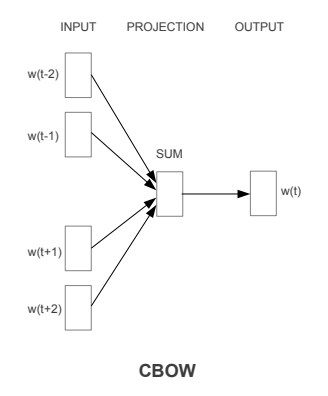

As a first step, let’s create our context and target sets.

In [6]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right

data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = raw_text[(i - CONTEXT_SIZE):(i)]+ raw_text[(i+1): (i+1 + CONTEXT_SIZE)]      
    target = raw_text[i]
    data.append((context, target))

print(data[:10])

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea'), (['the', 'idea', 'a', 'computational'], 'of'), (['idea', 'of', 'computational', 'process.'], 'a'), (['of', 'a', 'process.', 'Computational'], 'computational'), (['a', 'computational', 'Computational', 'processes'], 'process.'), (['computational', 'process.', 'processes', 'are'], 'Computational')]


In [7]:
vocab = set(raw_text)
vocab_size = len(vocab)
print(vocab_size)

49


Now that we created our dataset, our next step is to convert words into numbers.  
Luckily due to our small corpus, we only have 49 different words. Working on bigger datasets like Wikipedia or Twitter means working on vocabularies including thousands of words.


In [8]:
word_to_ix = {word: i for i, word in enumerate(vocab)}  # a dictionary that converts words to ids
ix_to_word = {ix:word for ix, word in enumerate(vocab)} # a dictionary that converts ids to words

print('word to ix converts word to numbers: word_to_ix["We"] ->', word_to_ix["We"])
print("ix to word converts word to numbers: ix_to_word[31] ->", ix_to_word[31])

word to ix converts word to numbers: word_to_ix["We"] -> 31
ix to word converts word to numbers: ix_to_word[28] -> program.


In [9]:
def make_context_vector(context, word_to_ix):  # function to convert our word array to  torch tensor
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

print("Make context vector function convert our data set to tensors:\n", data[0][0],"->", make_context_vector(data[0][0], word_to_ix))
print("\nFor target we can still use: \nword_to_ix[data[0][1]]->",word_to_ix[data[0][1]])

Make context vector function convert our data set to tensors:
 ['We', 'are', 'to', 'study'] -> tensor([31, 44, 32, 10])

For target we can still use: 
word_to_ix[data[0][1]]-> 33


### Network

Next, we will implement our network while utilizing the nn.Embedding module in our network.

In [10]:
class CBOWnetwork(nn.Module):

    def __init__(self, vocab_size, embedding_dim,hidden_dim):  
        super(CBOWnetwork, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)  
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)   
        self.relu1 = nn.ReLU()        
        self.linear2 = nn.Linear(hidden_dim, vocab_size)  # We need output size equal to vocab_size
        self.softmax = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)   # as CBOW model says we will sum our embeddings .view(1,-1) prepares  our output for next layer.
        x = self.linear1(embeds)
        x = self.relu1(x)

        x = self.linear2(x)
        x = self.softmax(x)   
        return x
        
    def get_word_embedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

The CBOW Network above contains two linear layers with RELU activation between layers, and a LogSoftMax layer at the end. This SoftMax function returns probability distribution over our vocabulary. 

Let’s initiate our network.

In [11]:
EMBEDDING_DIM = 5  # For this example, let's choose 5 as our embedding dimension. You are welcome to try different dimension sizes.
loss_function = nn.NLLLoss()  # The negative log-likelihood loss is useful when we have N classes.
HIDDEN_DIM = 10

model = CBOWnetwork(len(vocab), EMBEDDING_DIM,HIDDEN_DIM)   #If you want to work on the GPU, you can add the `.cuda()` to end. Because it is a small network, we will work on the CPU.

optimizer = torch.optim.SGD(model.parameters(), lr=0.001) 

Our last step is to train our network/embeddings. 

In [12]:
losses = []   # for keeping the losses
EPOCHS = 800  # because of our tiny dataset we need to increase our epoch count
j =0
for epoch in range(EPOCHS):    
    total_loss = 0
    i=0 
    j +=1
    for context, target in data:     #lets get our context and target
        
        # Remove the gradients for next iteration
        model.zero_grad()   
       
        # Convert the corpus in to integers.
        context_idxs = make_context_vector(context,word_to_ix)  
        #print("Context id: ",context_idxs)
      
        # forward pass
        log_probs = model(context_idxs)

        # calculate the Loss
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        #print(loss)

        # backward Pass
        loss.backward()

        # Gradient decent using optimizer 
        optimizer.step()
        i += 1
        # 
        total_loss += loss.item()
    if j%50 ==0:
      print("epoch", j ,"avarage epoch loss:", total_loss/i)
    losses.append(total_loss)


epoch 50 avarage epoch loss: 3.547443918113051
epoch 100 avarage epoch loss: 3.172199052983317
epoch 150 avarage epoch loss: 2.8295482386802804
epoch 200 avarage epoch loss: 2.4886438918524774
epoch 250 avarage epoch loss: 2.1404235085536696
epoch 300 avarage epoch loss: 1.8023953607370113
epoch 350 avarage epoch loss: 1.492953394250623
epoch 400 avarage epoch loss: 1.2293770349231259
epoch 450 avarage epoch loss: 1.010343200559246
epoch 500 avarage epoch loss: 0.8288299792670998
epoch 550 avarage epoch loss: 0.6781097398749714
epoch 600 avarage epoch loss: 0.5550598050628243
epoch 650 avarage epoch loss: 0.4554936982819746
epoch 700 avarage epoch loss: 0.37557054323882894
epoch 750 avarage epoch loss: 0.3118193883705756
epoch 800 avarage epoch loss: 0.2608311102436534


### Output

Now that we trained our network. Let's see a prediction example;

In [13]:
context = ['Computational','processes', 'abstract','beings']
context_vector = make_context_vector(context, word_to_ix)
result = model(context_vector)

print(f'Prediction: {ix_to_word[torch.argmax(result[0]).item()]}')

Prediction: are


In [14]:
context = ['We','study', 'abstract','things']  #let's try phrase that does not exist in our data
context_vector = make_context_vector(context, word_to_ix)
result = model(context_vector)

print(f'Prediction: {ix_to_word[torch.argmax(result[0]).item()]}')

Prediction: about


The `get_word_embeddings` function of our network returns trained embeddings of the given word.

In [15]:
model.get_word_embedding('are')

tensor([[ 0.9280, -0.3002,  0.1396,  0.1612,  1.7412]],
       grad_fn=<ViewBackward0>)

## Another CBOW example

We will now change our input to observe the quality of the embeddings.

In [16]:
raw_text = """We are about to study the idea of a computational process.
              We are about to learn the idea of a computational process.
              We are about to study the way of a computational process.
              We are about to learn the way of a computational process.""".split()

As you can see, the new text has 4 sentences that replace `study` with `learn` and `idea` with `way`. If we look at the CBOW model, embeddings of these words will be similar after training. Let’s create our network and observe the embeddings of these words while training.

In [17]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = raw_text[(i - CONTEXT_SIZE):(i)]+ raw_text[(i+1): (i+1 + CONTEXT_SIZE)]      
    target = raw_text[i]
    data.append((context, target))

In [18]:
vocab = set(raw_text)
vocab_size = len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}

In [19]:
class CBOWnetwork(nn.Module):
    def __init__(self, vocab_size, embedding_dim):  
        super(CBOWnetwork, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, vocab_size)   
        self.softmax = nn.LogSoftmax(dim = -1)
    def forward(self, inputs):
        embeds = torch.sum(self.embeddings(inputs),0).view(1,-1)
        x = self.linear1(embeds)
        x = self.softmax(x)
        return x
    def get_word_embedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

In [20]:
EMBEDDING_DIM = 1  
loss_function = nn.NLLLoss()  # The negative log likelihood loss is useful when we have N number of clases
model = CBOWnetwork(len(vocab), EMBEDDING_DIM)   #If you want to work on the GPU you can add the `.cuda()` to end. Because it is a small network, we will work on CPU.
optimizer = torch.optim.SGD(model.parameters(), lr=0.001) 

In [21]:
losses = []   # for keeping the losses
EPOCHS = 1601  # lower learning rate and small data

j=0
for epoch in range(EPOCHS):    
    total_loss = 0
    i=0 
    for context, target in data:     #lets get our context and target
        
        # Remove the gradients for next iteration
        model.zero_grad()   
       
        # Convert the corpus in to integers.
        context_idxs = make_context_vector(context,word_to_ix)  
        #print("Context id: ",context_idxs)
      
        # forward pass
        log_probs = model(context_idxs)

        # calculate the Loss
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        #print(loss)

        # backward Pass
        loss.backward()

        # Gradient decent using optimizer 
        optimizer.step()

        # 
        total_loss += loss.item()
        i +=1
    if j%100 ==0:
      print(f'epoch  {j}  avarage loss  {(total_loss/i):0}')
      model.eval()
      with torch.no_grad():
        print("study:", model.get_word_embedding('study').item(),"learn:", model.get_word_embedding('learn').item())
        print("idea:", model.get_word_embedding('idea').item(),"way:", model.get_word_embedding('way').item(), '\n')
      model.train()
    losses.append(total_loss)
    j += 1

epoch  0  avarage loss  3.5519193395972253
study: -0.6405587792396545 learn: 1.2428487539291382
idea: 0.05227378383278847 way: -0.21945291757583618 

epoch  100  avarage loss  2.5064186573028566
study: -0.536053478717804 learn: 1.178978443145752
idea: -0.0585571825504303 way: -0.3066433072090149 

epoch  200  avarage loss  2.2902836710214616
study: -0.43080416321754456 learn: 1.1217738389968872
idea: -0.16198143362998962 way: -0.38646429777145386 

epoch  300  avarage loss  2.0971345767378806
study: -0.2790960669517517 learn: 1.0647934675216675
idea: -0.21926042437553406 way: -0.41386085748672485 

epoch  400  avarage loss  1.940844613313675
study: -0.09532274305820465 learn: 1.0030118227005005
idea: -0.2566532790660858 way: -0.4173741042613983 

epoch  500  avarage loss  1.826148296892643
study: 0.09223043918609619 learn: 0.9500172138214111
idea: -0.286149263381958 way: -0.41590288281440735 

epoch  600  avarage loss  1.7426644623279572
study: 0.2573149502277374 learn: 0.9071144461631

After random initialization of the embedding layer, weights of these words start to converge with each epoch of training.